In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
SG_CRC_BA = pd.read_csv("SingaporeCRC_data/SG_CRC_BA", index_col=0,delimiter=",")
SG_CRC_BA

,g__Abyssalbus,g__Abyssibius,g__Abyssicoccus,g__Acaryochloris,g__Aceticella,g__Acetilactobacillus,g__Acetivibrio,g__Acetoanaerobium,g__Acetobacter,g__Acetobacterium,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
patient_id1,,,,,,,,,,,,,,,,,,,,,
1312.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,80.0,Descending colon,Left,2,T2N0(0/18)M0,I,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
1643.0,0.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,5.0,7.0,...,65.0,Rectum,Left,2,T2N0(0/20)M0,I,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
1586.0,0.0,1.0,0.0,0.0,5.0,0.0,66.0,0.0,1.0,13.0,...,63.0,Sigmoid colon,Left,2,T2N0(0/9)M0,I,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
1138.0,0.0,2.0,0.0,0.0,0.0,1.0,19.0,5.0,1.0,2.0,...,51.0,Sigmoid colon,Left,2,pT3N2(7/29)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
609.0,0.0,1.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,...,84.0,Ascending colon,Right,2,T3N0(0/12)M0,IIA,iCMS3,CMS3,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,65.0,Cecum,Right,2,T3N0(0/25)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
1253.0,0.0,2.0,0.0,0.0,0.0,5.0,36.0,8.0,0.0,8.0,...,39.0,Sigmoid colon,Left,2,T3N0(0/18)M0,IIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
1662.0,3.0,1.0,0.0,1.0,0.0,5.0,111.0,7.0,1.0,73.0,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS


In [3]:
class_counts = SG_CRC_BA['Vital.status'].value_counts()
print(class_counts)

Vital.status
Alive       72
Deceased    41
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = SG_CRC_BA.drop(['TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA', 'PIK3R1',
       'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2', 'Vital.status',
       'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_CRC_BA['Vital.status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Alive' 'Deceased']
Unique values of y: [0 1]


In [5]:
# Ensure class balance
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)


(144, 1905)
(144,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Score: 0.7299999999999999
Test Set Accuracy: 0.7272727272727273


<Figure size 800x600 with 0 Axes>

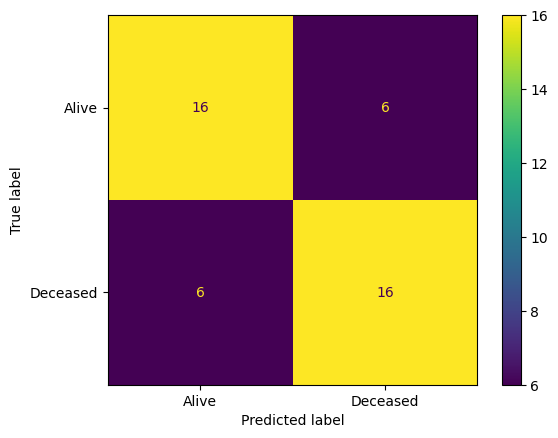

              precision    recall  f1-score   support

       Alive       0.73      0.73      0.73        22
    Deceased       0.73      0.73      0.73        22

    accuracy                           0.73        44
   macro avg       0.73      0.73      0.73        44
weighted avg       0.73      0.73      0.73        44



In [6]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [20, 50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive', 'Deceased'])
plt.figure(figsize=(8, 6)) 
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Alive', 'Deceased'])
print(report)

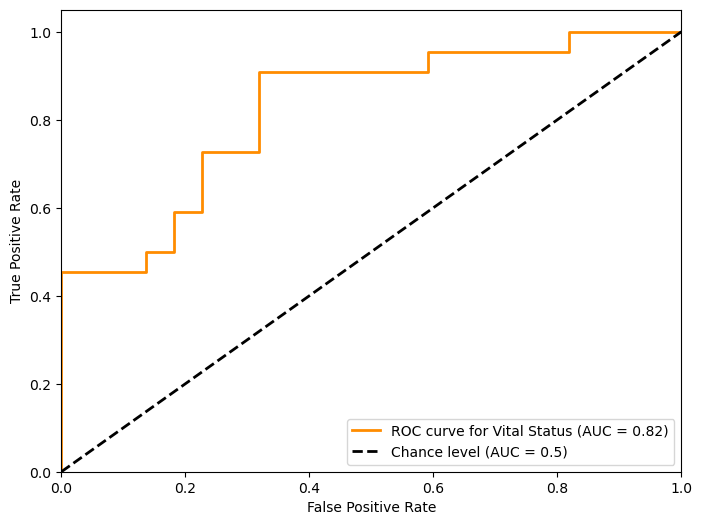

In [7]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for Vital Status (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_8836\951501840.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


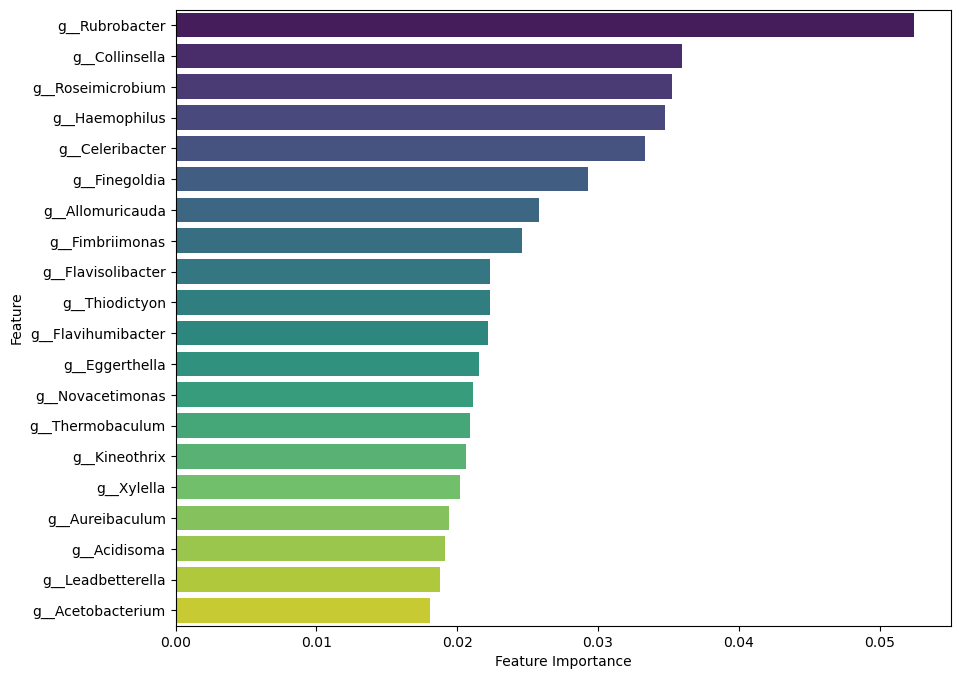

In [8]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

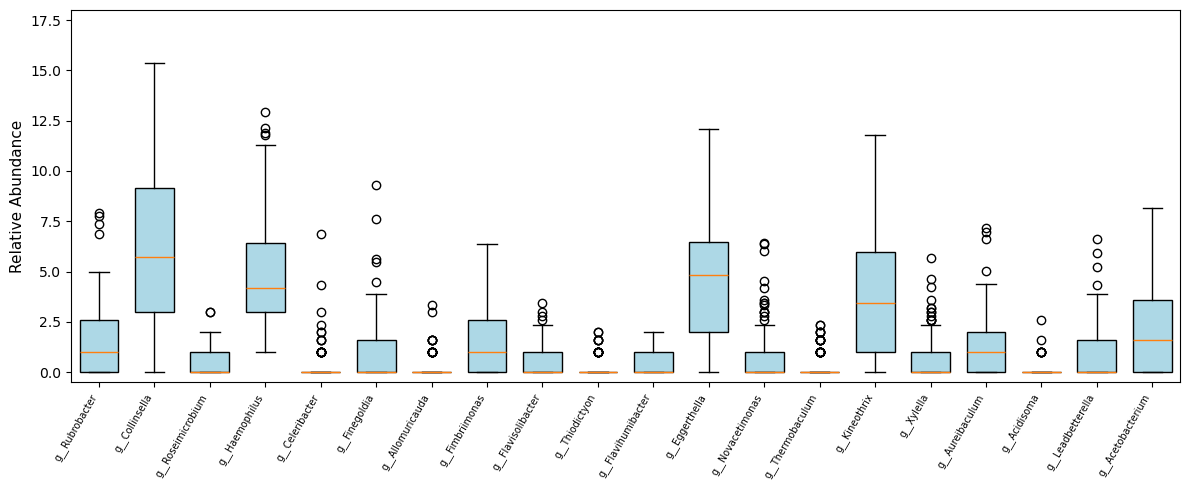

In [9]:
# Box plot for visualizing bacterial relative abundance of 20 most important bacteria
data = {}
top_20_feature_names = feature_names[top_20_indices]
abundance_scaled = np.log2(X+1)

for column_name in top_20_feature_names:
    data[column_name] = abundance_scaled[column_name]

plt.figure(figsize=(12, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-0.5, 18)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout() 
plt.show()